<a href="https://colab.research.google.com/github/KushagraIndurkhya/bilateral-filtering/blob/main/bilateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bilateral Filter : Major Project




## Configure opencv and input/output directories and files


In [ ]:
!apt-get update
!apt-get install -y libopencv-dev

In [ ]:
!find .. -name 'libopencv*'

In [ ]:
!pkg-config --cflags --libs opencv4

In [5]:
!mkdir -p output
!mkdir -p input
!wget "https://drive.google.com/uc?export=download&id=11A87h7OyeiavThxcRz6OeExEi7u---TC" -O input/original.png

--2023-04-04 18:57:55--  https://drive.google.com/uc?export=download&id=11A87h7OyeiavThxcRz6OeExEi7u---TC
Resolving drive.google.com (drive.google.com)... 74.125.24.138, 74.125.24.113, 74.125.24.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.24.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4rp0n33t7oahka131tlbmb73l4nl8602/1680634650000/07584919166158982710/*/11A87h7OyeiavThxcRz6OeExEi7u---TC?e=download&uuid=beda0db0-7140-4247-9175-28d3290a7efc [following]
--2023-04-04 18:57:56--  https://doc-0g-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4rp0n33t7oahka131tlbmb73l4nl8602/1680634650000/07584919166158982710/*/11A87h7OyeiavThxcRz6OeExEi7u---TC?e=download&uuid=beda0db0-7140-4247-9175-28d3290a7efc
Resolving doc-0g-10-docs.googleusercontent.com (doc-0g-10-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:

## Add noise to original image apply gaussian,mean,median filters for comparision

In [ ]:
!pip install scikit-image

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import log10, sqrt
from skimage.metrics import structural_similarity

  
def PSNR(im1, im2):
    im1=cv2.imread(im1)
    im2=cv2.imread(im2)
    mse = np.mean((im1-im2) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return structural_similarity(im1, im2)

   
diameter=3
sigma_for_gaussian=50


img=cv2.imread("input/original.png",0)
gauss_noise=np.zeros(img.shape,dtype=np.uint8)
cv2.randn(gauss_noise,128,10)
gauss_noise=(gauss_noise*0.8).astype(np.uint8)
gn_img=cv2.add(img,gauss_noise)
cv2.imwrite("input/input.png", gn_img)

img=cv2.imread("input/input.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussian_blur = cv2.GaussianBlur(gray, (diameter, diameter), sigma_for_gaussian)
cv2.imwrite("output/gaussian_blurred_image.png", gaussian_blur)

mean_filter=cv2.blur(img, (diameter, diameter))
cv2.imwrite("output/mean_filtered_image.png", mean_filter)

median_filter=cv2.medianBlur(img, diameter)
cv2.imwrite("output/median_filtered_image.png", median_filter)



True

# Writing our own bilateral filter implementation sequential and parallel (On CPU) in C++

In [8]:
%%writefile bilateral.cpp

#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <thread>
#include <chrono>

using namespace cv;
using namespace std;

float distance(int x, int y, int i, int j) {
    return float(sqrt(pow(x - i, 2) + pow(y - j, 2)));
}

float gaussian(float x, double sigma) {
    //return exp(-(pow(x, 2))/(2 * pow(sigma, 2))) / (2 * CV_PI * pow(sigma, 2));
    return expf(-0.5f * (x*x) / (sigma* sigma));

}

void applyBilateralFilter(Mat source, Mat filteredImage, int x, int y, int diameter, double sigmaI, double sigmaS) {
    double iFiltered = 0;
    double wP = 0;
    int neighbor_x = 0;
    int neighbor_y = 0;
    int half = diameter / 2;

    for(int i = 0; i < diameter; i++) {
        for(int j = 0; j < diameter; j++) {
            neighbor_x = x - (half - i);
            neighbor_y = y - (half - j);
            double gi = gaussian(source.at<uchar>(neighbor_x, neighbor_y) - source.at<uchar>(x, y), sigmaI);
            double gs = gaussian(distance(x, y, neighbor_x, neighbor_y), sigmaS);
            double w = gi * gs;
            iFiltered = iFiltered + source.at<uchar>(neighbor_x, neighbor_y) * w;
            wP = wP + w;
        }
    }
    iFiltered = iFiltered / wP;
    filteredImage.at<double>(x, y) = iFiltered;


}


Mat bilateralFilterSeq(Mat source, int diameter, double sigmaI, double sigmaS) {
    Mat filteredImage = Mat::zeros(source.rows,source.cols,CV_64F);
    int radius=0;

    int width = source.cols;
    int height = source.rows;

    for(int i = radius; i < height - radius; i++) {
        for(int j = radius; j < width - radius; j++) {
            applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
        }
    }
    return filteredImage;
}

Mat bilateralFilterParallel(Mat source, int diameter, double sigmaI, double sigmaS,int numThreads) {
    Mat filteredImage = Mat::zeros(source.rows, source.cols, CV_64F);
    int radius = 0;

    int width = source.cols;
    int height = source.rows;

    //int numThreads = thread::hardware_concurrency();
    
    vector<thread> threads;

    int rowsPerThread = height / numThreads;

    int start = radius;
    int end = start + rowsPerThread;

    for (int t = 0; t < numThreads; t++) {
        if (t == numThreads - 1) {
            end = height - radius;
        }

        threads.push_back(thread([&, start, end]() {
            for (int i = start; i < end; i++) {
                for (int j = radius; j < width - radius; j++) {
                    applyBilateralFilter(source, filteredImage, i, j, diameter, sigmaI, sigmaS);
                }
            }
        }));

        start = end;
        end = start + rowsPerThread;
    }

    for (auto &t : threads) {
        t.join();
    }

    return filteredImage;
}


int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter= atoi(argv[2]);
    int sigma_space= atoi(argv[3]);
    int sigma_intensity= atoi(argv[4]);
    int numThreads = 10;
    

    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageSeq = bilateralFilterSeq(src, diameter, sigma_intensity,sigma_space);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();


    start = chrono::high_resolution_clock::now();
    Mat filteredImageOpenCV;
    bilateralFilter(src, filteredImageOpenCV, diameter,sigma_intensity,sigma_space);
    end = chrono::high_resolution_clock::now();
    auto durationOpenCV = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    start = chrono::high_resolution_clock::now();
    Mat filteredImageParallel = bilateralFilterParallel(src, diameter, sigma_intensity,sigma_space,numThreads);
    end = chrono::high_resolution_clock::now();
    auto durationParallel = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Sequential: "<<durationSeq<<"ms \n";
    cout<<"Parallel: "<<durationParallel<<"ms"<<" using "<<numThreads<<" threads\n";

    imwrite("output/original_image_grayscale.png", src);
    imwrite("output/filtered_image_OpenCV.png", filteredImageOpenCV);
    imwrite("output/filtered_image_Seq.png", filteredImageSeq);
    imwrite("output/filtered_image_Parallel.png", filteredImageParallel);

    return 0;
}

Writing bilateral.cpp


## Compile and Run

In [9]:
!g++ -std=c++11 -pthread -I/usr/include/opencv4/opencv -I/usr/include/opencv4 bilateral.cpp -o bilateral -lopencv_stitching -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_highgui -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_line_descriptor -lopencv_quality -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_datasets -lopencv_text -lopencv_dnn -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [10]:
!./bilateral input/input.png 15 10 30

Sequential: 7184ms 
Parallel: 5392ms using 10 threads


# Writing our own bilateral filter implementation sequential and parallel (On GPU) in C++

## Not Working

In [ ]:
%%writefile bilateral_cuda.cu
#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>

#define TILE_SIZE 32

using namespace cv;
using namespace std;

__device__ float distance(int x, int y, int i, int j) {
    return float(sqrt(pow(x - i, 2) + pow(y - j, 2)));
}

__device__ double gaussian(float x, double sigma) {
    return exp(-(pow(x, 2))/(2 * pow(sigma, 2))) / (2 * CV_PI * pow(sigma, 2));
}

__global__ void applyBilateralFilterKernel(uchar* source, double* filteredImage, int width, int height, int diameter, double sigmaI, double sigmaS) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int BORDER_SIZE = diameter / 2;
    int extendedWidth = width + BORDER_SIZE;
    int extendedHeight = height + BORDER_SIZE;

    if (x >= BORDER_SIZE / 2 && x < width + BORDER_SIZE / 2 && y >= BORDER_SIZE / 2 && y < height + BORDER_SIZE / 2) {
        double iFiltered = 0;
        double wP = 0;
        int neighbor_x = 0;
        int neighbor_y = 0;
        int half = diameter / 2;

        for(int i = 0; i < diameter; i++) {
            for(int j = 0; j < diameter; j++) {
                neighbor_x = x - (half - i);
                neighbor_y = y - (half - j);
                double gi = gaussian(source[(neighbor_x + BORDER_SIZE / 2) * extendedWidth + neighbor_y + BORDER_SIZE / 2] - source[(x + BORDER_SIZE / 2) * extendedWidth + y + BORDER_SIZE / 2], sigmaI);
                double gs = gaussian(distance(x, y, neighbor_x, neighbor_y), sigmaS);
                double w = gi * gs;
                iFiltered = iFiltered + source[(neighbor_x + BORDER_SIZE / 2) * extendedWidth + neighbor_y + BORDER_SIZE / 2] * w;
                wP = wP + w;
            }
        }
        iFiltered = iFiltered / wP;
        filteredImage[x * width + y] = iFiltered;
    }
}




Mat bilateralFilterCUDA(Mat source, int diameter, double sigmaI, double sigmaS) {
    int width = source.cols;
    int height = source.rows;

    uchar *dev_source;
    cudaMalloc(&dev_source, width * height * sizeof(uchar));
    cudaMemcpy(dev_source, source.data, width * height * sizeof(uchar), cudaMemcpyHostToDevice);

    double *dev_filteredImage;
    cudaMalloc(&dev_filteredImage, width * height * sizeof(double));
    cudaMemset(dev_filteredImage, 0, width * height * sizeof(double));

    dim3 dimBlock(TILE_SIZE, TILE_SIZE);
    dim3 dimGrid((width + dimBlock.x - 1) / dimBlock.x, (height + dimBlock.y - 1) / dimBlock.y);

    applyBilateralFilterKernel<<<dimGrid, dimBlock>>>(dev_source, dev_filteredImage, width, height, diameter, sigmaI, sigmaS);

    Mat filteredImage = Mat::zeros(height, width, CV_64F);
    cudaDeviceSynchronize();
    cudaMemcpy(filteredImage.ptr<double>(), dev_filteredImage, width * height * sizeof(double), cudaMemcpyDeviceToHost);

    cudaFree(dev_source);
    cudaFree(dev_filteredImage);

    filteredImage.convertTo(filteredImage, CV_8UC1);

    return filteredImage;
}


int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter= atoi(argv[2]);
    int sigma_space= atoi(argv[3]);
    int sigma_intensity= atoi(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_intensity,sigma_space);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Cuda: "<<durationSeq<<"ms \n";

    imwrite("output/cuda_gen.png", filteredImageCuda);
}


Overwriting bilateral_cuda.cu


## Working

In [11]:
%%writefile bilateral_cuda.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__device__ float gaussianSpace(float spatial_distance, float sigma_space) {
    return expf(-0.5f * (spatial_distance * spatial_distance) / (sigma_space * sigma_space));
}

__global__ void bilateralFilterKernel(const unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= cols || y >= rows) {
        return;
    }

    float intensity_sum = 0;
    float weight_sum = 0;

    for (int j = -diameter; j <= diameter; j++) {
        for (int i = -diameter; i <= diameter; i++) {
            int neighbor_x = x + i;
            int neighbor_y = y + j;

            if (neighbor_x < 0 || neighbor_y < 0 || neighbor_x >= cols || neighbor_y >= rows) {
                continue;
            }

            int src_index = neighbor_y * cols + neighbor_x;
            int dst_index = y * cols + x;

            float intensity_diff = src[src_index] - src[dst_index];
            float spatial_distance = sqrt((float)(i * i + j * j));
            float weight = gaussianIntensity(intensity_diff, sigma_intensity) * gaussianSpace(spatial_distance, sigma_space);

            intensity_sum += src[src_index] * weight;
            weight_sum += weight;
        }
    }

    dst[y * cols + x] = (unsigned char)(intensity_sum / weight_sum);
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    int rows = src.rows;
    int cols = src.cols;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen.png", filteredImageCuda);
}


Writing bilateral_cuda.cu


## Compile and run

In [12]:
%%shell
nvcc --version
nvcc -o bilateral_cuda bilateral_cuda.cu `pkg-config --cflags --libs opencv4`
nvprof ./bilateral_cuda input/input.png 15 10 30
ncu ./bilateral_cuda input/input.png 15 10 30

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridde

## Gaussian-spatial precompute optimization

In [13]:
%%writefile bilateral_cuda_opt1.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__device__ float gaussianSpace(float spatial_distance, float sigma_space) {
    return expf(-0.5f * (spatial_distance * spatial_distance) / (sigma_space * sigma_space));
}

__global__ void bilateralFilterKernel(const unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity,float* spatial_lookup) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= cols || y >= rows) {
        return;
    }

    float intensity_sum = 0;
    float weight_sum = 0;

    for (int j = -diameter; j <= diameter; j++) {
        for (int i = -diameter; i <= diameter; i++) {
            int neighbor_x = x + i;
            int neighbor_y = y + j;

            if (neighbor_x < 0 || neighbor_y < 0 || neighbor_x >= cols || neighbor_y >= rows) {
                continue;
            }

            int src_index = neighbor_y * cols + neighbor_x;
            int dst_index = y * cols + x;

            float intensity_diff = src[src_index] - src[dst_index];
            float spatial_weight = spatial_lookup[(i+diameter)*diameter+(j+diameter)];
            float weight = gaussianIntensity(intensity_diff, sigma_intensity) * spatial_weight;


            intensity_sum += src[src_index] * weight;
            weight_sum += weight;
        }
    }

    dst[y * cols + x] = (unsigned char)(intensity_sum / weight_sum);
}

float* computeSpatialLookup(int diameter, float sigma_space) {
    int max_distance = 2*diameter+1;
    float* spatial_lookup = new float[max_distance*max_distance];
    float spatial_distance;
    int t_i, t_j;

    for (int i = 0; i <= max_distance; i++) {
      for (int j=0; j<=max_distance; j++) {
        t_i = i-diameter;
        t_j = j-diameter;
        spatial_distance = sqrt((float)(t_i * t_i + t_j * t_j));
        spatial_lookup[i*diameter + j] = expf(-0.5f * spatial_distance / (sigma_space * sigma_space));
      }
    }

    return spatial_lookup;
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    float* dev_spatial_lookup;
    int rows = src.rows;
    int cols = src.cols;
    float* SpatialLookup=computeSpatialLookup(diameter,sigma_space);

    int lookup_row = 2*diameter+1;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_spatial_lookup, sizeof(float)*lookup_row*lookup_row);

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_spatial_lookup, SpatialLookup, sizeof(float)*lookup_row*lookup_row, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);


    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity,dev_spatial_lookup);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen_opt1.png", filteredImageCuda);
}

Writing bilateral_cuda_opt1.cu


In [14]:
%%shell
nvcc --version
nvcc -o bilateral_cuda_opt1 bilateral_cuda_opt1.cu `pkg-config --cflags --libs opencv4`
nvprof ./bilateral_cuda_opt1 input/input.png 15 10 30
ncu ./bilateral_cuda_opt1 input/input.png 15 10 30

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridde

# Shared Memory Optimization


In [20]:
%%writefile bilateral_cuda_sm.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

#define THREADS_PER_BLOCK_Y 16
#define THREADS_PER_BLOCK_X 16
#define DIAMETER 30

// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__global__ void bilateralFilterKernel(const unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity, float* spatial_lookup) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= cols || y >= rows) {
        return;
    }

    // Allocate shared memory for a subset of the source image
    __shared__ unsigned char shared_src[THREADS_PER_BLOCK_Y + 2 * DIAMETER][THREADS_PER_BLOCK_X + 2 * DIAMETER];

    // Compute the indices for the shared memory subset
    int shared_x = threadIdx.x + diameter;
    int shared_y = threadIdx.y + diameter;

    // Load the subset of the source image into shared memory
    shared_src[shared_y][shared_x] = src[y * cols + x];
    if (threadIdx.x < diameter) {
        shared_src[shared_y][shared_x - diameter] = (x - diameter >= 0) ? src[y * cols + x - diameter] : 0;
        shared_src[shared_y][shared_x + THREADS_PER_BLOCK_X] = (x + THREADS_PER_BLOCK_X < cols) ? src[y * cols + x + THREADS_PER_BLOCK_X] : 0;
    }
    if (threadIdx.y < diameter) {
        shared_src[shared_y - diameter][shared_x] = (y - diameter >= 0) ? src[(y - diameter) * cols + x] : 0;
        shared_src[shared_y + THREADS_PER_BLOCK_Y][shared_x] = (y + THREADS_PER_BLOCK_Y < rows) ? src[(y + THREADS_PER_BLOCK_Y) * cols + x] : 0;
    }
    if (threadIdx.x < diameter && threadIdx.y < diameter) {
        shared_src[shared_y - diameter][shared_x - diameter] = (x - diameter >= 0 && y - diameter >= 0) ? src[(y - diameter) * cols + x - diameter] : 0;
        shared_src[shared_y - diameter][shared_x + THREADS_PER_BLOCK_X] = (x + THREADS_PER_BLOCK_X < cols && y - diameter >= 0) ? src[(y - diameter) * cols + x + THREADS_PER_BLOCK_X] : 0;
        shared_src[shared_y + THREADS_PER_BLOCK_Y][shared_x - diameter] = (x - diameter >= 0 && y + THREADS_PER_BLOCK_Y < rows) ? src[(y + THREADS_PER_BLOCK_Y) * cols + x - diameter] : 0;
        shared_src[shared_y + THREADS_PER_BLOCK_Y][shared_x + THREADS_PER_BLOCK_X] = (x + THREADS_PER_BLOCK_X < cols && y + THREADS_PER_BLOCK_Y < rows) ? src[(y + THREADS_PER_BLOCK_Y) * cols + x + THREADS_PER_BLOCK_X] : 0;
    }

    __syncthreads();

    float intensity_sum = 0;
    float weight_sum = 0;

    for (int j = -diameter; j <= diameter; j++) {
        for (int i = -diameter; i <= diameter; i++){
        int neighbor_shared_x = shared_x + i;
        int neighbor_shared_y = shared_y + j;

        int src_index = (y + j) * cols + (x + i);
        int dst_index = y * cols + x;

        float intensity_diff = shared_src[neighbor_shared_y][neighbor_shared_x] - shared_src[shared_y][shared_x];
        float spatial_weight = spatial_lookup[(i + diameter) * diameter + (j + diameter)];
        float weight = gaussianIntensity(intensity_diff, sigma_intensity) * spatial_weight;

        intensity_sum += shared_src[neighbor_shared_y][neighbor_shared_x] * weight;
        weight_sum += weight;
    }
    }
    dst[y * cols + x] = (unsigned char)(intensity_sum / weight_sum);
}


float* computeSpatialLookup(int diameter, float sigma_space) {
    int max_distance = 2*diameter+1;
    float* spatial_lookup = new float[max_distance*max_distance];
    float spatial_distance;
    int t_i, t_j;

    for (int i = 0; i <= max_distance; i++) {
      for (int j=0; j<=max_distance; j++) {
        t_i = i-diameter;
        t_j = j-diameter;
        spatial_distance = sqrt((float)(t_i * t_i + t_j * t_j));
        spatial_lookup[i*diameter + j] = expf(-0.5f * spatial_distance / (sigma_space * sigma_space));
      }
    }

    return spatial_lookup;
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    float* dev_spatial_lookup;
    int rows = src.rows;
    int cols = src.cols;
    float* SpatialLookup=computeSpatialLookup(diameter,sigma_space);

    int lookup_row = 2*diameter+1;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_spatial_lookup, sizeof(float)*lookup_row*lookup_row);

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_spatial_lookup, SpatialLookup, sizeof(float)*lookup_row*lookup_row, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);


    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity,dev_spatial_lookup);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen_sm.png", filteredImageCuda);
}

Overwriting bilateral_cuda_sm.cu


In [30]:
%%shell
nvcc --version
nvcc -o bilateral_cuda_sm bilateral_cuda_sm.cu `pkg-config --cflags --libs opencv4`
# nvprof --events shared_st_bank_conflict ./bilateral_cuda_sm input/input.png 15 10 30
# ncu ./bilateral_cuda_sm input/input.png 15 10 30
# ncu --metrics l1tex__data_bank_conflicts_pipe_lsu_mem_shared_op_st ./bilateral_cuda_sm input/input.png 15 10 30
# ncu --metrics l1tex__data_bank_conflicts_pipe_lsu_mem_shared_op_ld ./bilateral_cuda_sm input/input.png 15 10 30
ncu --metrics group:memory__shared_table ./bilateral_cuda_sm input/input.png 15 10 30

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridde

# Optimization 2: Seperate gaussian filter in 1d row and col

In [ ]:
%%writefile bilateral_cuda_opt2.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;


// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__device__ float gaussianSpace(float spatial_distance, float sigma_space) {
    return expf(-0.5f * (spatial_distance * spatial_distance) / (sigma_space * sigma_space));
}

__constant__ float spatial_lookup_const[256];

float* computeSpatialLookup(int diameter, float sigma_space) {
    int max_distance = 2 * diameter + 1;
    float* spatial_lookup = new float[max_distance * max_distance];
    float spatial_distance;
    int t_i, t_j;

    for (int i = 0; i < max_distance; i++) {
        for (int j = 0; j < max_distance; j++) {
            t_i = i - diameter;
            t_j = j - diameter;
            spatial_distance = sqrt((float)(t_i * t_i + t_j * t_j));
            spatial_lookup[i * max_distance + j] = expf(-0.5f * spatial_distance / (sigma_space * sigma_space));
        }
    }

    cudaMemcpyToSymbol(spatial_lookup_const, spatial_lookup, sizeof(float) * max_distance * max_distance);

    delete[] spatial_lookup;
    return nullptr;
}

__global__ void bilateralFilterKernel(unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity) {
    __shared__ float spatialLookup[25];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x * blockDim.x;
    int by = blockIdx.y * blockDim.y;
    int x = bx + tx;
    int y = by + ty;

    int lookup_row = 2*diameter+1;

    // Copy spatial lookup values to shared memory
    if(tx < lookup_row && ty < lookup_row) {
        int i = ty * lookup_row + tx;
        spatialLookup[i] = computeWeight(tx - diameter, ty - diameter, sigma_space);
    }

    __syncthreads();

    if (x < cols && y < rows) {
        float sum = 0.0f;
        float weightSum = 0.0f;
        int index = y * cols + x;
        int centerPixel = src[index];

        for (int i = -diameter; i <= diameter; i++) {
            for (int j = -diameter; j <= diameter; j++) {
                int neighborX = x + j;
                int neighborY = y + i;

                if (neighborX >= 0 && neighborX < cols && neighborY >= 0 && neighborY < rows) {
                    int neighborIndex = neighborY * cols + neighborX;
                    int neighborPixel = src[neighborIndex];

                    float spatialWeight = spatialLookup[(i+diameter) * lookup_row + (j+diameter)];
                    float intensityWeight = computeWeight(centerPixel - neighborPixel, 0, sigma_intensity);
                    float weight = spatialWeight * intensityWeight;

                    sum += neighborPixel * weight;
                    weightSum += weight;
                }
            }
        }

        dst[index] = static_cast<unsigned char>(sum / weightSum);
    }
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    float* dev_spatial_lookup;
    int rows = src.rows;
    int cols = src.cols;
    float* SpatialLookup=computeSpatialLookup(diameter,sigma_space);

    int lookup_row = 2*diameter+1;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_spatial_lookup, sizeof(float)*lookup_row*lookup_row);

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    //cudaMemcpy(dev_spatial_lookup, SpatialLookup, sizeof(float)*lookup_row*lookup_row, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);


    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols,sigma_space, sigma_intensity);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen_opt2.png", filteredImageCuda);
}

Writing bilateral_cuda_opt2.cu


In [ ]:
%%writefile bilateral_cuda_opt2.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>


#define M_PI           3.14159265358979323846
#define TILE_X 16
#define TILE_Y 16


using namespace std;
using namespace cv;

// 1D Gaussian kernel array values of a fixed size (make sure the number > filter size d)
__constant__ float cGaussian[64];

// Initialize texture memory to store the input
texture<unsigned char, 2, cudaReadModeElementType> inTexture;

/* 
   GAUSSIAN IN 1D FOR SPATIAL DIFFERENCE
   Here, exp(-[(x_centre - x_curr)^2 + (y_centre - y_curr)^2]/(2*sigma*sigma)) can be broken down into ...
   exp[-(x_centre - x_curr)^2 / (2*sigma*sigma)] * exp[-(y_centre - y_curr)^2 / (2*sigma*sigma)] 
   i.e, 2D gaussian -> product of two 1D Gaussian
   A constant Gaussian 1D array can be initialzed to store the gaussian values
   Eg: For a kernel size 5, the pixel difference array will be ...
   [-2, -1, 0, 1 , 2] for which the gaussian kernel is applied
*/
void updateGaussian(int r, double sd)
{
    float fGaussian[64];
    for (int i = 0; i < 2*r + 1; i++)
    {
        float x = i - r;
        fGaussian[i] = expf(-(x*x) / (2 * sd*sd));
    }
    cudaMemcpyToSymbol(cGaussian, fGaussian, sizeof(float)*(2*r + 1));
}

// Gaussian function for range difference
__device__ inline double gaussian(float x, double sigma)
{
    return __expf(-(powf(x, 2)) / (2 * powf(sigma, 2)));
}

// Bilateral filter kernel
__global__ void bilateralFilterKernel(unsigned char* input, unsigned char* output,
    int width, int height,
    int r, double sI, double sS)
{
    // Initialize global Tile indices along x,y and xy
    int txIndex = __mul24(blockIdx.x, TILE_X) + threadIdx.x;
    int tyIndex = __mul24(blockIdx.y, TILE_Y) + threadIdx.y;

    // If within image size
    if ((txIndex < width) && (tyIndex < height))
    {
        double iFiltered = 0;
        double wP = 0;
        // Get the centre pixel value
        unsigned char centrePx = tex2D(inTexture, txIndex, tyIndex);
        // Iterate through filter size from centre pixel
        for (int dy = -r; dy <= r; dy++) {
            for (int dx = -r; dx <= r; dx++) {
                // Get the current pixel value
                unsigned char currPx = tex2D(inTexture, txIndex + dx, tyIndex + dy);
                // Weight = 1D Gaussian(x_axis) * 1D Gaussian(y_axis) * Gaussian(Range or Intensity difference)
                double w = (cGaussian[dy + r] * cGaussian[dx + r]) * gaussian(centrePx - currPx, sI);
                iFiltered += w * currPx;
                wP += w;
            }
        }
        output[tyIndex*width + txIndex] = iFiltered / wP;
    }
}

Mat bilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    float* dev_spatial_lookup;
    int rows = src.rows;
    int cols = src.cols;
    //float* SpatialLookup=computeSpatialLookup(diameter,sigma_space);

    int lookup_row = 2*diameter+1;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_spatial_lookup, sizeof(float)*lookup_row*lookup_row);

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    //cudaMemcpy(dev_spatial_lookup, SpatialLookup, sizeof(float)*lookup_row*lookup_row, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);


    bilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = bilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/cuda_gen_opt2.png", filteredImageCuda);
}

Overwriting bilateral_cuda_opt2.cu


In [ ]:
%%shell
rm ./bilateral_cuda_opt2
nvcc -o bilateral_cuda_opt2 bilateral_cuda_opt2.cu `pkg-config --cflags --libs opencv4`
nvprof ./bilateral_cuda_opt2 input/input.png 15 10 30



rm: cannot remove './bilateral_cuda_opt2': No such file or directory
gcc: error: bilateral_cuda_opt2.cu: No such file or directory
gcc: warning: ‘-x c++’ after last input file has no effect
gcc: fatal error: no input files
compilation terminated.
======== Error: application not found.


CalledProcessError: ignored

# Anisotropic diffusion


In [15]:
%%writefile anisotropic.cpp

#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <opencv2/ximgproc.hpp>
#include <thread>
#include <chrono>

using namespace cv;
using namespace std;

Mat anisotropicDiffusionSeq(Mat src, int numIterations, float delta_t, float kappa) {
    Mat filteredImage = src.clone();
    Mat prevImage = src.clone();

    int rows = src.rows;
    int cols = src.cols;

    for (int i = 0; i < numIterations; i++) {
        for (int r = 1; r < rows-1; r++) {
            for (int c = 1; c < cols-1; c++) {
                float diff_n = filteredImage.at<uchar>(r-1, c) - filteredImage.at<uchar>(r, c);
                float diff_s = filteredImage.at<uchar>(r+1, c) - filteredImage.at<uchar>(r, c);
                float diff_w = filteredImage.at<uchar>(r, c-1) - filteredImage.at<uchar>(r, c);
                float diff_e = filteredImage.at<uchar>(r, c+1) - filteredImage.at<uchar>(r, c);

                float grad_n = exp(-(diff_n*diff_n) / (kappa*kappa));
                float grad_s = exp(-(diff_s*diff_s) / (kappa*kappa));
                float grad_w = exp(-(diff_w*diff_w) / (kappa*kappa));
                float grad_e = exp(-(diff_e*diff_e) / (kappa*kappa));

                float diff_nw = filteredImage.at<uchar>(r-1, c-1) - filteredImage.at<uchar>(r, c);
                float diff_ne = filteredImage.at<uchar>(r-1, c+1) - filteredImage.at<uchar>(r, c);
                float diff_sw = filteredImage.at<uchar>(r+1, c-1) - filteredImage.at<uchar>(r, c);
                float diff_se = filteredImage.at<uchar>(r+1, c+1) - filteredImage.at<uchar>(r, c);

                float grad_nw = exp(-(diff_nw*diff_nw) / (kappa*kappa));
                float grad_ne = exp(-(diff_ne*diff_ne) / (kappa*kappa));
                float grad_sw = exp(-(diff_sw*diff_sw) / (kappa*kappa));
                float grad_se = exp(-(diff_se*diff_se) / (kappa*kappa));

                float diffusionCoefficient = delta_t * (grad_n*diff_n + grad_s*diff_s + grad_w*diff_w + grad_e*diff_e
                                                        + grad_nw*diff_nw + grad_ne*diff_ne + grad_sw*diff_sw + grad_se*diff_se);

                filteredImage.at<uchar>(r, c) = prevImage.at<uchar>(r, c) + diffusionCoefficient;
            }
        }

        prevImage = filteredImage.clone();
    }

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1],IMREAD_COLOR);
    cout << "Here";
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }
    auto start = chrono::high_resolution_clock::now();
    //Mat filteredImageSeq = anisotropicDiffusionSeq(src, 50, 0.25, 0.2);
    Mat filteredImageSeq;
    cv::ximgproc::anisotropicDiffusion(src, filteredImageSeq, 10, 0.1, 1); // apply anisotropic diffusion
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();

    cout<<"Sequential: "<<durationSeq<<"ms \n";


    imwrite("output/filtered_image_Seq_anisotropic.png", filteredImageSeq);

    return 0;
}

Writing anisotropic.cpp


In [ ]:
%%shell
g++ -std=c++11 -pthread -I/usr/include/opencv4/opencv -I/usr/include/opencv4 anisotropic.cpp -o anisotropic -lopencv_stitching -lopencv_aruco -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_highgui -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_line_descriptor -lopencv_quality -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_datasets -lopencv_text -lopencv_dnn -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [ ]:
!./anisotropic input/input.png

HereSequential: 7ms 


# NL Means Bilateral Filter (Naive)

In [16]:
%%writefile bilateral_nlmeans.cu
#include <iostream>
#include <chrono>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace std;
using namespace cv;

// Function to calculate the gaussian weight based on intensity difference
__device__ float gaussianIntensity(float intensity_diff, float sigma_intensity) {
    return expf(-0.5f * (intensity_diff * intensity_diff) / (sigma_intensity * sigma_intensity));
}

// Function to calculate the gaussian weight based on spatial distance
__device__ float gaussianSpace(float spatial_distance, float sigma_space) {
    return expf(-0.5f * (spatial_distance * spatial_distance) / (sigma_space * sigma_space));
}

__global__ void nonLocalBilateralFilterKernel(const unsigned char* src, unsigned char* dst, int rows, int cols, int diameter, float sigma_space, float sigma_intensity, float sigma_range) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= cols || y >= rows) {
        return;
    }

    float intensity_sum = 0;
    float weight_sum = 0;

    for (int j = 0; j < rows; j++) {
        for (int i = 0; i < cols; i++) {
            int neighbor_x = i;
            int neighbor_y = j;

            int src_index = neighbor_y * cols + neighbor_x;
            int dst_index = y * cols + x;

            float intensity_diff = src[src_index] - src[dst_index];
            float spatial_distance = sqrt((float)((x - neighbor_x) * (x - neighbor_x) + (y - neighbor_y) * (y - neighbor_y)));
            float range_diff = src[src_index] - src[dst_index];
            float weight = gaussianIntensity(intensity_diff, sigma_intensity) * gaussianSpace(spatial_distance, sigma_space) * gaussianIntensity(range_diff, sigma_range);

            intensity_sum += src[src_index] * weight;
            weight_sum += weight;
        }
    }

    dst[y * cols + x] = (unsigned char)(intensity_sum / weight_sum);
}

Mat nonLocalBilateralFilterCUDA(const Mat& src, int diameter, float sigma_space, float sigma_intensity, float sigma_range) {
    Mat filteredImage(src.rows, src.cols, CV_8UC1);
    filteredImage.setTo(0);

    unsigned char* dev_src = nullptr;
    unsigned char* dev_dst = nullptr;
    int rows = src.rows;
    int cols = src.cols;

    cudaMalloc((void**)&dev_src, rows * cols * sizeof(unsigned char));
    cudaMalloc((void**)&dev_dst, rows * cols * sizeof(unsigned char));

    cudaMemcpy(dev_src, src.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);
    cudaMemcpy(dev_dst, filteredImage.data, rows * cols * sizeof(unsigned char), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 numBlocks((cols + threadsPerBlock.x - 1) / threadsPerBlock.x, (rows + threadsPerBlock.y - 1) / threadsPerBlock.y);

    nonLocalBilateralFilterKernel<<<numBlocks, threadsPerBlock>>>(dev_src, dev_dst, rows, cols, diameter, sigma_space, sigma_intensity, sigma_range);

    cudaMemcpy(filteredImage.data, dev_dst, rows * cols * sizeof(unsigned char), cudaMemcpyDeviceToHost);

    cudaFree(dev_src);
    cudaFree(dev_dst);

    return filteredImage;
}

int main(int argc, char** argv ) {
    Mat src;
    src = imread( argv[1], 0 );
    int diameter = atoi(argv[2]);
    float sigma_space = atof(argv[3]);
    float sigma_intensity = atof(argv[4]);
    float sigma_range=atof(argv[4]);
    
    if ( !src.data )
    {
        printf("No image data \n");
        return -1;
    }

    auto start = chrono::high_resolution_clock::now();
    Mat filteredImageCuda = nonLocalBilateralFilterCUDA(src, diameter, sigma_space, sigma_intensity,sigma_range);
    auto end = chrono::high_resolution_clock::now();
    auto durationSeq = chrono::duration_cast<chrono::milliseconds>(end - start).count();
    cout<<"Cuda: "<<durationSeq<<"ms \n";
    imwrite("output/nl_means.png", filteredImageCuda);
}




Writing bilateral_nlmeans.cu


In [17]:
%%shell
nvcc -o bilateral_nlmeans bilateral_nlmeans.cu `pkg-config --cflags --libs opencv4`
nvprof ./bilateral_nlmeans input/input.png 15 10 30 16
ncu ./bilateral_nlmeans input/input.png 15 10 30 16

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/videostab/motion_stabilizing.hpp(106): warning #997-D: function "cv::videostab::IMotionStabilizer::stabilize(int, const std::vector<cv::

# Plot out Results

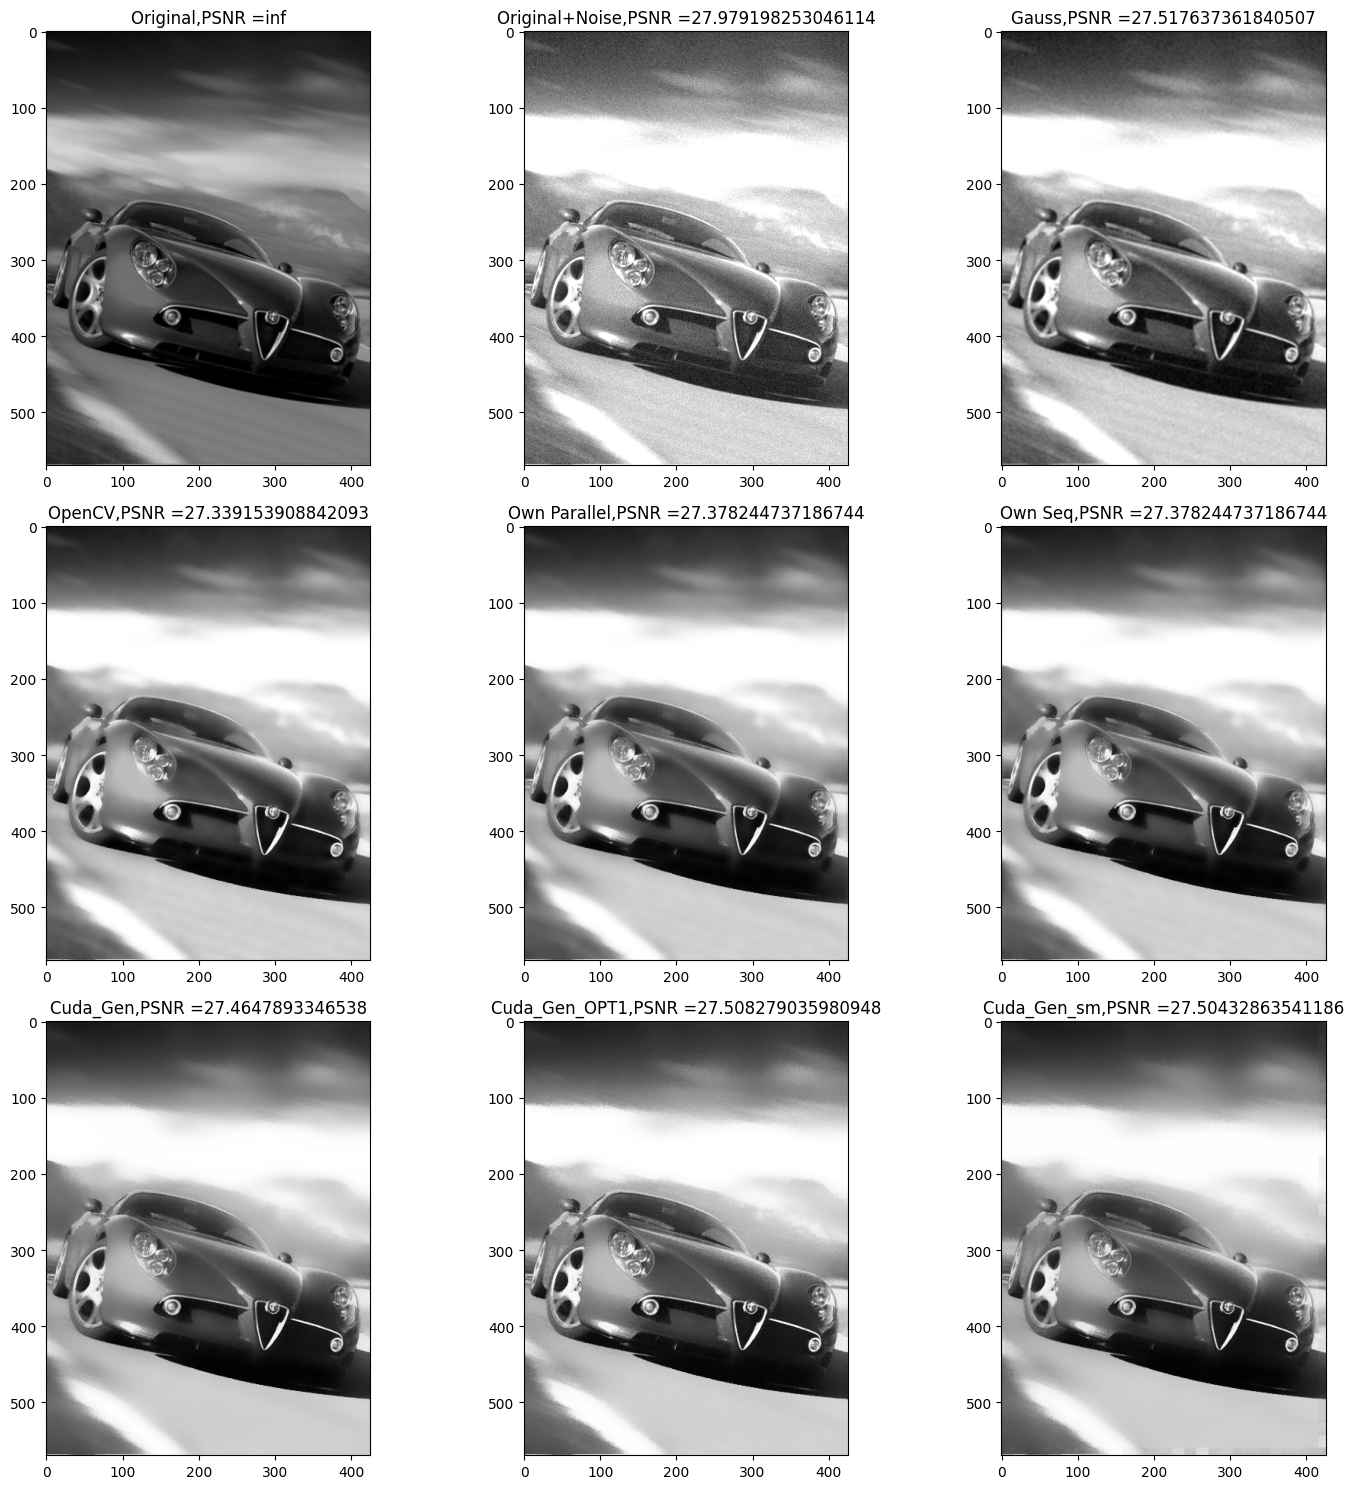

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import log10, sqrt
from skimage.metrics import structural_similarity,mean_squared_error,peak_signal_noise_ratio

  
def PSNR(im1, im2):
    im1=cv2.imread(im1,0)
    im2=cv2.imread(im2,0)
    mse = np.mean((im1 - im2) ** 2)
    if mse == 0:
        return float('inf')

    # Compute PSNR
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel /sqrt(mse))
    return psnr
    return peak_signal_noise_ratio(im1, im2,data_range=255)
# base_image_location="output/original_image_grayscale.png"
base_image_location="input/original.png"

img0,im0psnr = mpimg.imread("input/original.png"),PSNR(base_image_location,"input/original.png")
img1,im1psnr = mpimg.imread("output/original_image_grayscale.png"),PSNR(base_image_location,"output/original_image_grayscale.png")
img2,im2psnr = mpimg.imread("output/filtered_image_Parallel.png"),PSNR(base_image_location,"output/filtered_image_Parallel.png")
img3,im3psnr = mpimg.imread("output/filtered_image_Seq.png"),PSNR(base_image_location,"output/filtered_image_Seq.png")
img4,im4psnr = mpimg.imread("output/mean_filtered_image.png"),PSNR(base_image_location,"output/mean_filtered_image.png")
img5,im5psnr = mpimg.imread("output/median_filtered_image.png"),PSNR(base_image_location,"output/median_filtered_image.png")
img6,im6psnr= mpimg.imread("output/gaussian_blurred_image.png"),PSNR(base_image_location,"output/gaussian_blurred_image.png")
img7,im7psnr = mpimg.imread("output/filtered_image_OpenCV.png"),PSNR(base_image_location,"output/filtered_image_OpenCV.png")
img8,im8psnr = mpimg.imread("output/cuda_gen.png"),PSNR(base_image_location,"output/cuda_gen.png")
img9,im9psnr = mpimg.imread("output/cuda_gen_sm.png"),PSNR(base_image_location,"output/cuda_gen_sm.png")
img10,im10psnr = mpimg.imread("output/nl_means.png"),PSNR(base_image_location,"output/nl_means.png")
img11,im11psnr = mpimg.imread("output/cuda_gen_opt1.png"),PSNR(base_image_location,"output/cuda_gen_opt1.png")

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs[0,0].imshow(img0, cmap='gray')
axs[0,0].set_title("Original,PSNR ="+str(im0psnr))

axs[0,1].imshow(img1, cmap='gray')
axs[0,1].set_title("Original+Noise,PSNR ="+str(im1psnr))

axs[0,2].imshow(img6, cmap='gray')
axs[0,2].set_title("Gauss,PSNR ="+str(im6psnr))


axs[1,0].imshow(img7, cmap='gray')
axs[1,0].set_title("OpenCV,PSNR ="+str(im7psnr))

axs[1,1].imshow(img2, cmap='gray')
axs[1,1].set_title("Own Parallel,PSNR ="+str(im2psnr))

axs[1,2].imshow(img3, cmap='gray')
axs[1,2].set_title("Own Seq,PSNR ="+str(im3psnr))


axs[2,0].imshow(img8, cmap='gray')
axs[2,0].set_title("Cuda_Gen,PSNR ="+str(im8psnr))

axs[2,1].imshow(img10,cmap='gray')
axs[2,1].set_title("Cuda_Gen_OPT1,PSNR ="+str(im11psnr))

axs[2,2].imshow(img9, cmap='gray')
axs[2,2].set_title("Cuda_Gen_sm,PSNR ="+str(im9psnr))



# axs[2,2].imshow(img10,cmap='gray')
# axs[2,2].set_title("NL Means,PSNR ="+str(im10psnr))




plt.tight_layout()
plt.show()

In [ ]:
!rm -r input output
!rm bilateral bilateral.cpp